In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

65536/61306 [================================] - 0s 0us/step


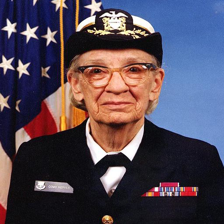

In [5]:
#getting sample image ffrom internet for testing
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [6]:
#converting image in the shape of 0 to 1 range
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
# we need a batch for the prediction as models always want, so we add batch dimenstion and pass the model for prediction 
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
#now we wxtract the class with highest probability using argmax function
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

16384/10484 [==============================================] - 0s 0us/step


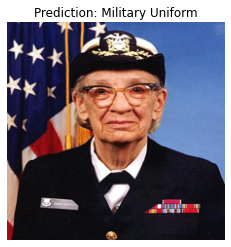

In [9]:
# here we are decoding the class by downloading class labels of the dataset
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

USING TENSORFLOW HUB FOR OUR DATASET OF CATS AND DOGS.

In [10]:
(train_examples, val_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteAB1HEU/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape {}".format(i+1, example_image[0].shape))

Image 1 shape (262, 350, 3)
Image 2 shape (409, 336, 3)
Image 3 shape (493, 500, 3)


In [12]:
# now we need to reformat all images to the resolution expected by out pre trained model
def format_images(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32
train_batches = train_examples.shuffle(num_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches = val_examples.map(format_images).batch(BATCH_SIZE).prefetch(1)

In [13]:
#Running the classifier on the batch of images
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names


array(['Egyptian cat', 'tabby', 'tabby', 'Bernese mountain dog',
       'miniature pinscher', 'schipperke', 'Egyptian cat', 'Persian cat',
       'Egyptian cat', 'malinois', 'German shepherd', 'lynx', 'tabby',
       'Egyptian cat', 'Persian cat', 'Siamese cat', 'Labrador retriever',
       'tiger cat', 'golden retriever', 'Egyptian cat', 'hand blower',
       'Scottish deerhound', 'Brabancon griffon', 'Great Dane',
       'Labrador retriever', 'Egyptian cat', 'Siamese cat',
       'Labrador retriever', 'tabby', 'whippet', 'Egyptian cat',
       'whippet'], dtype='<U30')

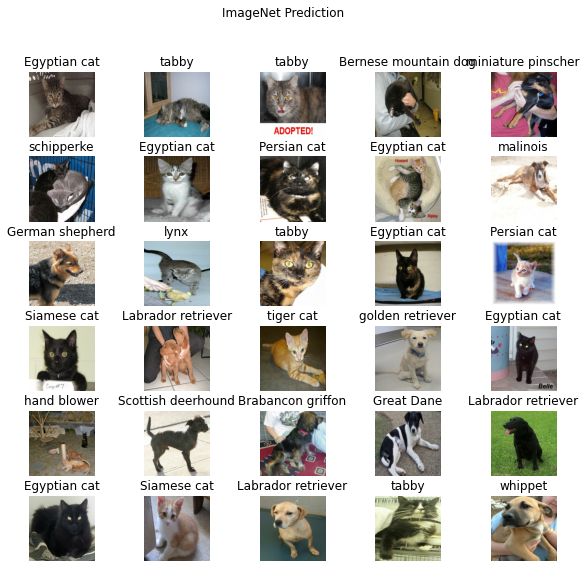

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
  _=plt.suptitle("ImageNet Prediction")

In [15]:
#Calling partial model for transfer learning without the last classification layer as this will do the most work of identifying the content of an image, except creating a probab distribution
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [17]:
feature_extractor.trainable=False # freezing the parameters and features of the pretrained model

In [18]:
#attaching the last classification layer according to our requirement of classes
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
# Training the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
Epochs = 6
history = model.fit(train_batches,
                    epochs=Epochs,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0506 - accuracy: 0.9834 - val_loss: 0.0321 - val_accuracy: 0.9884
Epoch 2/6
582/582 [==============================] - 57s 98ms/step - loss: 0.0298 - accuracy: 0.9895 - val_loss: 0.0333 - val_accuracy: 0.9895
Epoch 3/6
582/582 [==============================] - 57s 98ms/step - loss: 0.0247 - accuracy: 0.9917 - val_loss: 0.0334 - val_accuracy: 0.9888
Epoch 4/6
582/582 [==============================] - 57s 98ms/step - loss: 0.0209 - accuracy: 0.9930 - val_loss: 0.0326 - val_accuracy: 0.9905
Epoch 5/6
582/582 [==============================] - 56s 97ms/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 0.0346 - val_accuracy: 0.9886
Epoch 6/6
582/582 [==============================] - 56s 97ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0325 - val_accuracy: 0.9905


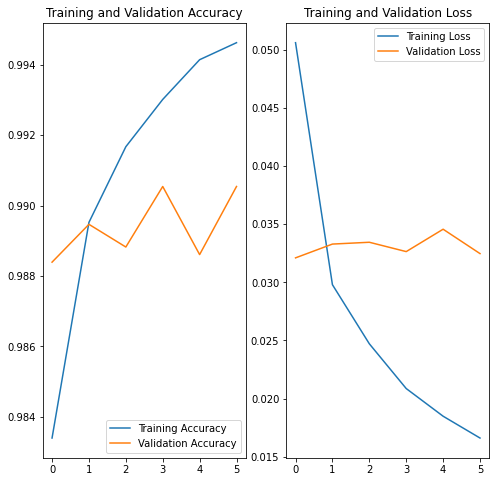

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#checking the predictions

class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [24]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat',
       'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'dog'], dtype='<U3')

In [25]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1]
Predicted labels:  [0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1]


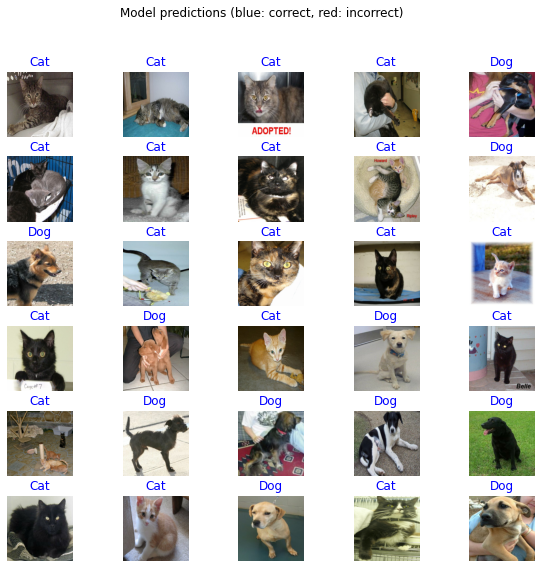

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")